In [1]:
import xarray as xr, hvplot.xarray, cartopy, cartopy.crs as crs, holoviews as hv, geoviews as gv
import numpy as np, metpy, metpy.calc as mpcalc, matplotlib.pyplot as plt, pandas as pd 

from metpy.units import units as mpunits
from MSEplots import plots as mpt
from functools import partial


np.warnings.filterwarnings('ignore') # otherwise metpy creates a ton of them

<a name="import"></a>
---------
## Load the bundled (zidv) dataset for the case
#### Download and provide path or chose the download link from here [Igel long-lived "water vapor island" cases -- Repository](http://weather.rsmas.miami.edu/repository/entry/show?entryid=cea25c8d-b05a-4d47-aa2b-bdb06c5453b2)

In [5]:
#zidvfile = 'https://weather.rsmas.miami.edu/repository/entry/get/Igel_WEIO_case_1997-02-27.zidv?entryid=d11a9c13-0e3e-4bd3-acb9-fd041c417a15'
zidvfile = '/Users/bem/Jupyter/Igel_WEIO_case_2007-08-13.zidv'

#### A utility to open the local or remote dataset

In [6]:
from os.path import isfile, join
from zipfile import ZipFile
import xarray
from io import BytesIO
from urllib.request import urlopen
def from_zidv(fileorurl=None,outdir=None):
    """Loading data from IDV zip file '.zidv' as xarray Dataset
    fileorurl can be a local .zidv file or a remote url.
    Optionally, outdir can be specified where the file is unzipped"""
    if fileorurl.startswith('http'):
        zfile = urlopen(fileorurl)
        zfile = BytesIO(zfile.read())
    elif isfile(fileorurl):
        zfile=fileorurl
    else:
        return 'Unknown File or Url'
    das=dict()
    with ZipFile(zfile) as zip_file:
        for contained_file in zip_file.namelist():
            if str(contained_file).startswith('data'):
                try:
                    das.update({contained_file:xarray.open_dataset(zip_file.extract(contained_file,outdir))})
                except Exception as err:
                    print('Skipping file '+str(contained_file)+' because of error '+err)
    return das
xarray.from_zidv=from_zidv

In [7]:
datasets_in_zidv=xr.from_zidv(zidvfile)
datasets_in_zidv.keys() #keys of datasets in xidv file

dict_keys(['data_0_MERRA23Ddata', 'data_1_ERAI2D3h@NCAR', 'data_2_MERRA22Dfields', 'data_3_ERAI3DatNCAR-RDA', 'data_4_GridSat-Aggregation'])

#### Load datasets and match times

In [8]:
merra2d=datasets_in_zidv['data_2_MERRA22Dfields']
merra3d=datasets_in_zidv['data_0_MERRA23Ddata']
erai2d=datasets_in_zidv['data_1_ERAI2D3h@NCAR']
erai3d=datasets_in_zidv['data_3_ERAI3DatNCAR-RDA']

#match times of all the datasets to 6h erai3d 

merra2d=merra2d.sel(time=erai3d.time) # match times of both datasets
merra3d=merra3d.sel(time=erai3d.time)

if 'time1' in erai2d.keys():
    erai2d=erai2d.rename({'time1':'time'})

erai2d=erai2d.sel(time=erai3d.time)

erai2d.time.attrs['long_name']='time' # a bug fix for hvplot

In [9]:
#pick some time,lat,lon values
time=merra3d.time.values[0]
lat=merra3d.lat.values[10]
lon=merra3d.lon.values[20]

# MERRA probe

***WARNING***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometirc equation


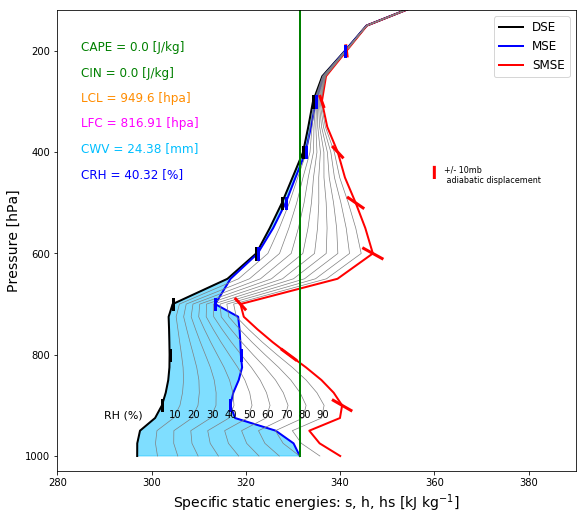

In [10]:

entrain = False # doesnt work for probes on MERRA or ERAI

sel_da= merra3d.sel(time=time,method='nearest').sel(lon=lon,lat=lat,method='nearest')
T  = sel_da.t
p  = sel_da.lev[~np.isnan(T)].values*mpunits.millibar 
rh = sel_da.rh[~np.isnan(T)].values

T  = T[~np.isnan(T)].values*mpunits.K

T  = T.to(mpunits.degC)
qv = mpcalc.mixing_ratio_from_relative_humidity(rh,T,p)

mpt.msed_plots(np.array(p),np.array(T),np.array(qv),altitude=[],entrain=entrain)

In [11]:
qv

<Quantity([ 1.37967668e-02  1.32604922e-02  1.15120906e-02  6.78509391e-03
  5.80385020e-03  5.73365700e-03  5.97894260e-03  6.16694395e-03
  6.04652509e-03  6.02229620e-03  5.97935376e-03  5.90180009e-03
  3.61576968e-03  2.60139635e-04  1.24962221e-04  2.88475001e-04
  3.16761589e-04  2.53382743e-04  2.20057746e-04  2.29869811e-04
  2.35593668e-04  1.09677965e-04  2.43051953e-05  1.47305712e-05
  6.71215187e-06  5.06480297e-06  4.77424853e-06  4.77902658e-06
  4.73881696e-06  4.59399732e-06  4.70804758e-06  5.05750069e-06
  5.66614882e-06  5.72917798e-06  6.31081476e-06 -1.05262787e-05
 -4.83841536e-06 -4.13832240e-06 -3.96225967e-06 -4.30667270e-06
 -5.48225998e-06  1.29450915e-05], 'dimensionless')>

# clipping qv to 0

***WARNING***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometirc equation


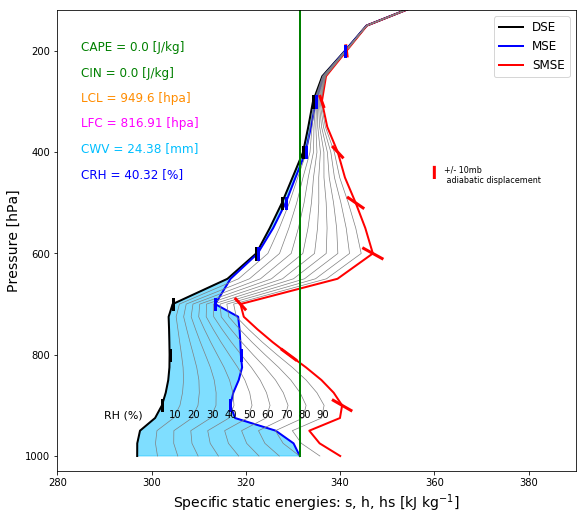

In [17]:

entrain = False # doesnt work for probes on MERRA or ERAI

sel_da= merra3d.sel(time=time,method='nearest').sel(lon=lon,lat=lat,method='nearest')
T  = sel_da.t
p  = sel_da.lev[~np.isnan(T)].values*mpunits.millibar 
rh = sel_da.rh[~np.isnan(T)].values

T  = T[~np.isnan(T)].values*mpunits.K

T  = T.to(mpunits.degC)
qv = mpcalc.mixing_ratio_from_relative_humidity(rh,T,p)

qv=np.where(qv>0,qv,1e-19)

mpt.msed_plots(np.array(p),np.array(T),np.array(qv),altitude=[],entrain=entrain)

In [13]:
qv

array([1.37967668e-02, 1.32604922e-02, 1.15120906e-02, 6.78509391e-03,
       5.80385020e-03, 5.73365700e-03, 5.97894260e-03, 6.16694395e-03,
       6.04652509e-03, 6.02229620e-03, 5.97935376e-03, 5.90180009e-03,
       3.61576968e-03, 2.60139635e-04, 1.24962221e-04, 2.88475001e-04,
       3.16761589e-04, 2.53382743e-04, 2.20057746e-04, 2.29869811e-04,
       2.35593668e-04, 1.09677965e-04, 2.43051953e-05, 1.47305712e-05,
       6.71215187e-06, 5.06480297e-06, 4.77424853e-06, 4.77902658e-06,
       4.73881696e-06, 4.59399732e-06, 4.70804758e-06, 5.05750069e-06,
       5.66614882e-06, 5.72917798e-06, 6.31081476e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.29450915e-05])

# selecting levels by values and indexes

***WARNING***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometirc equation


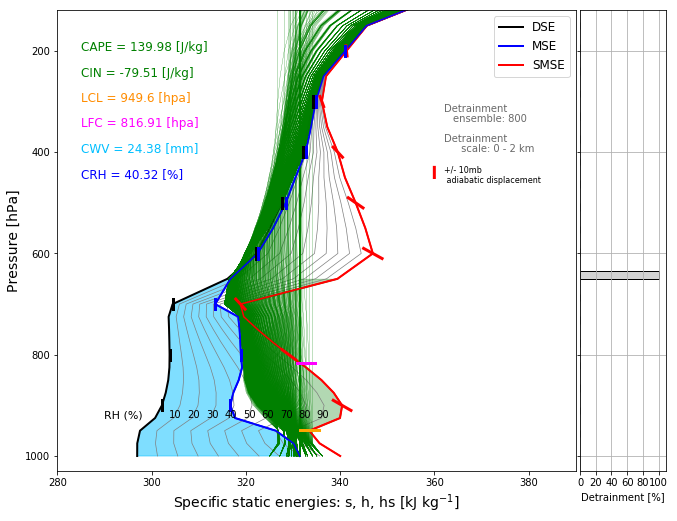

In [18]:

entrain = True # doesnt work for probes on MERRA or ERAI

sel_da= merra3d.sel(time=time,method='nearest').sel(lon=lon,lat=lat,method='nearest')

sel_da=sel_da.sel(lev=slice(1000,1)) #works
#sel_da=sel_da.sel(lev=slice(1000,200)) #doesnt work

#sel_da=sel_da.isel(lev=slice(0,37)) #works


T  = sel_da.t
p  = sel_da.lev[~np.isnan(T)].values*mpunits.millibar 
rh = sel_da.rh[~np.isnan(T)].values

T  = T[~np.isnan(T)].values*mpunits.K

T  = T.to(mpunits.degC)
qv = mpcalc.mixing_ratio_from_relative_humidity(rh,T,p)

qv=np.where(qv>0,qv,1e-9)

mpt.msed_plots(np.array(p),np.array(T),np.array(qv),altitude=[],entrain=entrain)

# ERAI probe

In [15]:
time=merra3d.time.values[0]
lat=merra3d.lat.values[10]
lon=merra3d.lon.values[20]

***WARNING***: the altitude at the surface is assumed 0 meter, and altitudes are derived based on the hypsometirc equation


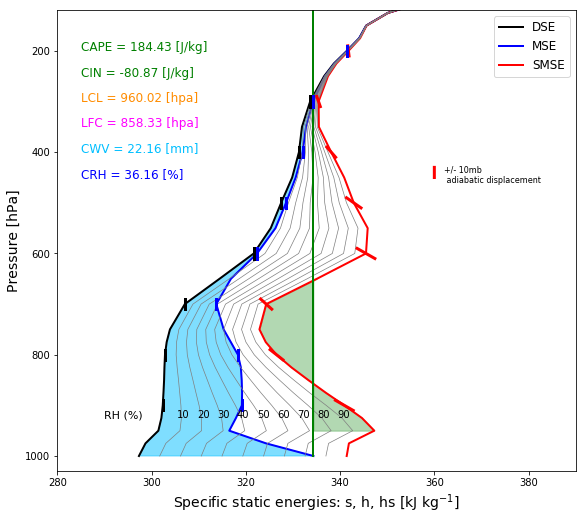

In [16]:
entrain = False # doesnt work for probes on MERRA or ERAI

sel_da= erai3d.sel(time=time,method='nearest').sel(lon=lon,lat=lat,method='nearest')

# make sure levels are ordered decreasing pressure

T  = sel_da.Temperature_isobaric[::-1]
p  = sel_da.isobaric[::-1][~np.isnan(T)].values*mpunits.millibar 
rh = sel_da.Relative_humidity_isobaric[::-1][~np.isnan(T)].values/100.0 #here given in percent

T  = T[~np.isnan(T)].values*mpunits.K
T  = T.to(mpunits.degC)
qv = mpcalc.mixing_ratio_from_relative_humidity(rh,T,p)
mpt.msed_plots(np.array(p),np.array(T),np.array(qv),altitude=[],entrain=entrain)